<a href="https://colab.research.google.com/github/raniaAprilia/Capstone-Project-SDI-2025/blob/main/Capstone_Project_SDI_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.2 MB/s eta 0:00:00


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/trip-advisor-hotel-reviews

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/5.14M [00:00<?, ?B/s]
100% 5.14M/5.14M [00:00<00:00, 800MB/s]


In [5]:
!unzip /content/trip-advisor-hotel-reviews.zip

Archive:  /content/trip-advisor-hotel-reviews.zip
  inflating: tripadvisor_hotel_reviews.csv  


In [6]:
import os
import pandas as pd

df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


## Labelling

In [7]:
def label_sentiment(rating):
  if rating <= 2:
    return 'Negative'
  elif rating >= 4:
    return 'Positive'
  else:
    return 'Neutral'

df['Sentiment'] = df['Rating'].apply(label_sentiment)
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

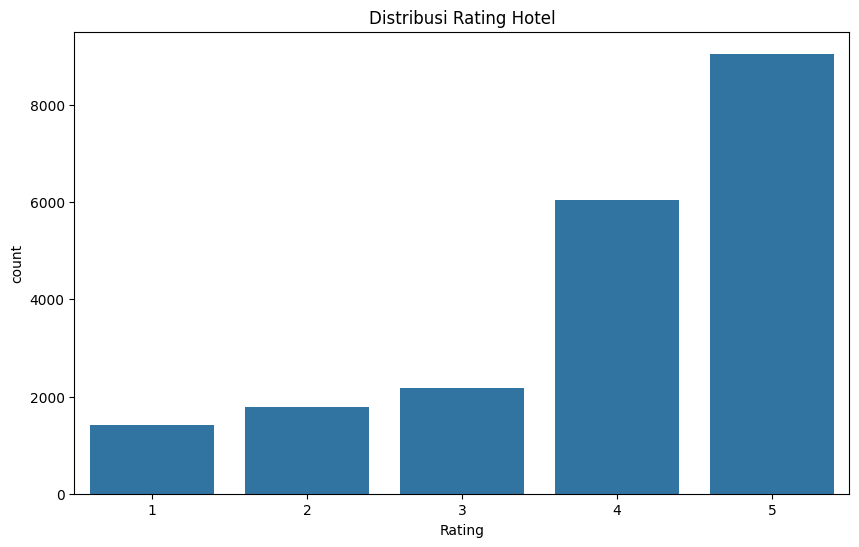

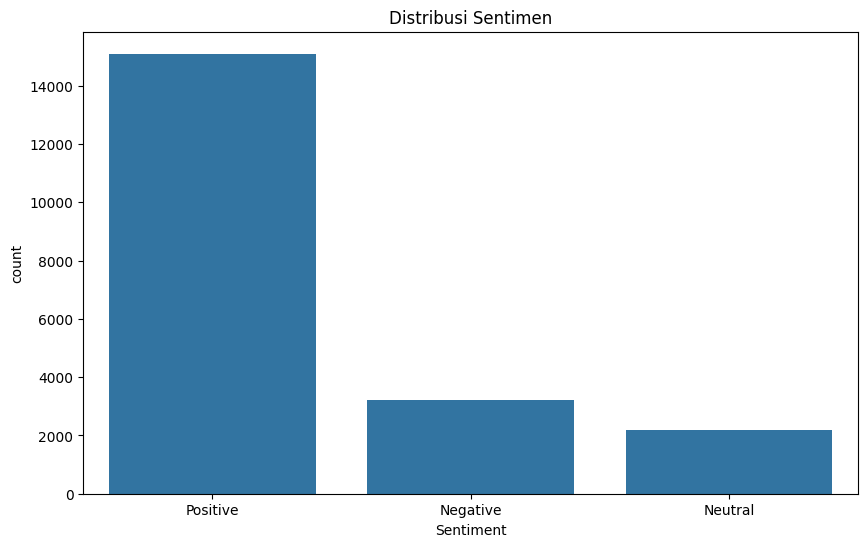

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df)
plt.title('Distribusi Rating Hotel')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.show()

## Preprocessing

In [18]:
df['Cleaned_Review'] = df['Review'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
sample_reviews = df[['Cleaned_Review', 'Sentiment']].sample(20, random_state=42)
customer_reviews = sample_reviews['Cleaned_Review'].tolist()
formatted_reviews = [f"- {review}" for review in customer_reviews]
formatted_review_str = "\n".join(formatted_reviews)

In [19]:
df.head()

,Review,Rating,Sentiment,Cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,Positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,Negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral,nice rooms not 4 experience hotel monaco seatt...
3,"unique, great stay, wonderful time hotel monac...",5,Positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,Positive,great stay great stay went seahawk game awesom...


## Data Distribution


In [24]:
prompt = f"""
Anda adalah seorang analis sentimen profesional untuk review hotel. Analisis review berikut dengan struktur berikut:

=== REVIEW ===
{formatted_review_str}

=== INSTRUKSI ANALISIS ===
- Berikan 3 aspek utama untuk setiap review review
- Berikan 1 sentimen utama untuk setiap review
- Berikan 2 rekomendasi untuk pengelola hotel untuk memperbaiki review negatif


"""

print(prompt)


Anda adalah seorang analis sentimen profesional untuk review hotel. Analisis review berikut dengan struktur berikut:

=== REVIEW ===
- not recommend hotel did reviewers actually stay hotel did good thing hotel location really close leidseplein shared facilities filthy got did not look toilet floor cleaned month facilities not cleaned 3 days got disgusting staff rude complained left night early refused refund night not recommend hotel  
- barcelona rocks stayed hotel jazz girlfriend 3 nights end augustthe hotel excellent location carrer pelai close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds caught airport bus barcelona costs 7 euros person return trip hotel located 2 mins walk maximum placa universitat stop 2nd route hotel modern clean air conditioning room superb balcony looking street outside room good size bathroom fine scrimp bit toiletries bring shower gels unless consider washing unnecessary luxury travelsthe downside hotel possibly strengths depen

In [22]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token

parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 8192,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0,
  "stopping_criteria": "length (1024 tokens)",
  "stopping_sequence": None
}

model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
    model=model,
    replicate_api_token = api_token,
    input=parameters
    )

In [25]:
response = output(prompt)
import re

output_clean = re.sub(r"\*\*(.*?)\*\*", r"\1", response)
print(output_clean)

## Analisis Sentimen dan Aspek Utama untuk Setiap Review Hotel

### Review 1:
Aspek Utama:
1. Lokasi Hotel
2. Kemudahan Bersihannya
3. Tata Letak dan Tata Letak

Sentimen Utama: Negatif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki dan meningkatkan frekuensi pembersihan kamar, kamar mandi, dan kemudahan umum.
2. Atasi masalah tata letak yang tidak baik, seperti tetapannya kamar yang tidak sehat.

### Review 2:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan Pelanggan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Sebabkan ruang kamar sudah diberi tingkat kepuasan, tetapi perlu mempertimbangkan pilihan kamar dengan tampilan luar yang lebih menarik.
2. Perbaiki sistem informasi tentang waktu penutupan lounge bar, agar tamu dapat plan lebih baik.

### Review 3:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kemudahan dan Layanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel

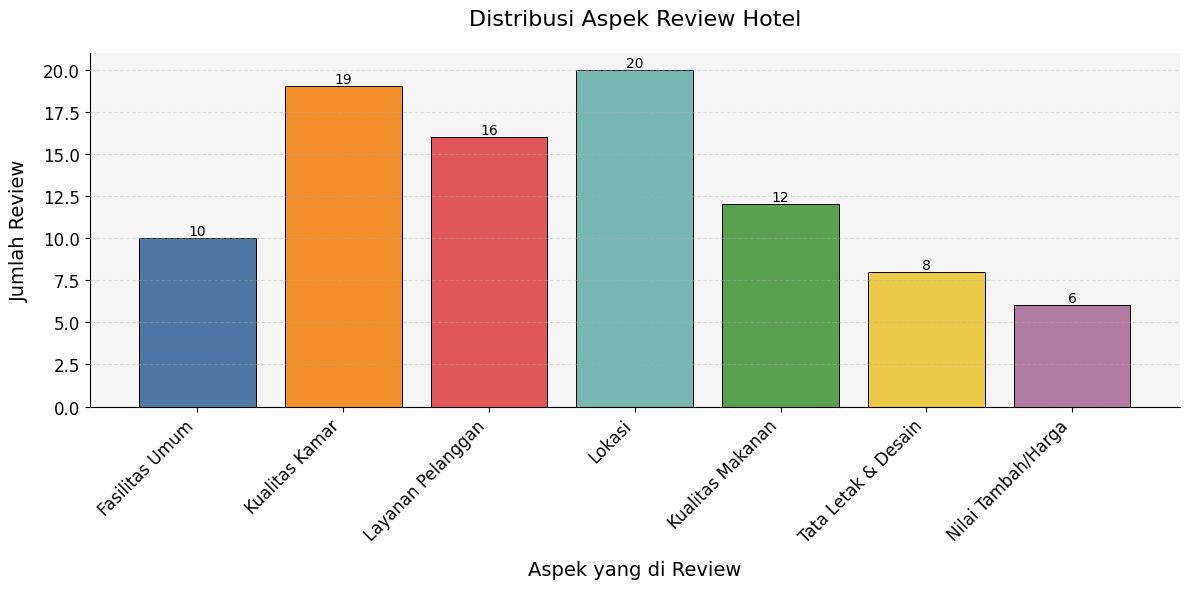

In [29]:

# Data klasifikasi hasil output IBM Granite
aspect = ['Fasilitas Umum', 'Kualitas Kamar', 'Layanan Pelanggan', 'Lokasi', 'Kualitas Makanan', 'Tata Letak & Desain', 'Nilai Tambah/Harga']
counts = [10, 19, 16, 20, 12, 8, 6]  # Sesuaikan ini dengan jumlah aspirasi dari output

# Set inclusive color palette (colorblind-friendly)
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948', '#B07AA1']

# Create figure with accessible settings
plt.figure(figsize=(12, 6))
bars = plt.bar(aspect, counts, color=colors, edgecolor='black', linewidth=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# Customize title and labels with larger font
plt.title("Distribusi Aspek Review Hotel", fontsize=16, pad=20)
plt.xlabel("Aspek yang di Review", fontsize=14, labelpad=10)
plt.ylabel("Jumlah Review", fontsize=14, labelpad=10)

# Improve x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add grid and background for better readability
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.gca().set_facecolor('#f5f5f5')

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [40]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Data review (contoh dari input Anda)
reviews = [f"""
## Analisis Sentimen dan Aspek Utama untuk Setiap Review Hotel

### Review 1:
Aspek Utama:
1. Lokasi Hotel
2. Kemudahan Bersihannya
3. Tata Letak dan Tata Letak

Sentimen Utama: Negatif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki dan meningkatkan frekuensi pembersihan kamar, kamar mandi, dan kemudahan umum.
2. Atasi masalah tata letak yang tidak baik, seperti tetapannya kamar yang tidak sehat.

### Review 2:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan Pelanggan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Sebabkan ruang kamar sudah diberi tingkat kepuasan, tetapi perlu mempertimbangkan pilihan kamar dengan tampilan luar yang lebih menarik.
2. Perbaiki sistem informasi tentang waktu penutupan lounge bar, agar tamu dapat plan lebih baik.

### Review 3:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kemudahan dan Layanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Pertimbangkan untuk meningkatkan kualitas minibar dan menawarkan pilihan makanan yang lebih kompetitif.

### Review 4:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem minuman dan makanan di restoran hotel, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Atasi masalah tata letak di beach area, seperti penyediaan tempat tinggal yang lebih banyak untuk penginapan.

### Review 5:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 6:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 7:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 8:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 9:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 10:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 11:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 12:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 13:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 14:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 15:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 16:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 17:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 18:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.

### Review 19:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Kualitas Makanan

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki kualitas dan pilihan makanan di restoran hotel utama, khususnya untuk mencegah kesalahan pembelian dan meningkatkan kepuasan tamu.
2. Pertimbangkan untuk menawarkan lebih banyak pilihan di restoran hotel, termasuk pilihan makanan yang lebih variatif.

### Review 20:
Aspek Utama:
1. Lokasi Hotel
2. Kualitas Kamar
3. Layanan dan Tata Letak

Sentimen Utama: Positif

Rekomendasi untuk Pengelola Hotel:
1. Perbaiki sistem akses internet dan jaringan Wi-Fi di seluruh hotel, termasuk ruang kamar, untuk memastikan pengalaman tamu yang lancar.
2. Atasi masalah tata letak di ruang kamar, seperti penyediaan tempat tinggal yang lebih banyak untuk barang pribadi tamu.
""" ] # List berisi semua review yang Anda berikan

# Ekstrak semua rekomendasi
all_recommendations = []
for review in reviews:
    recommendations = re.findall(r"Rekomendasi untuk Pengelola Hotel:\n(.*?)(?:\n\n|\Z)", review, re.DOTALL)
    if recommendations:
        # Pisahkan setiap poin rekomendasi
        points = [point.strip() for point in recommendations[0].split('\n') if point.strip()]
        all_recommendations.extend(points)

# Simpan ke file teks
with open('rekomendasi_hotel.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(all_recommendations))

In [49]:
# Gabungkan semua rekomendasi
text = " ".join(all_recommendations)

# Bersihkan teks
clean_text = re.sub(r"[^\w\s]", " ", text.lower())  # Hapus tanda baca dan ubah ke lowercase

# Hitung frekuensi kata
word_freq = Counter(clean_text.split())

# Filter kata umum (stopwords)
stopwords = {'untuk', 'dan', 'yang', 'atasi', 'seperti', 'di', 'pada', 'agar', 'lebih', 'dengan', 'hotel', 'masalah', 'umum'}
filtered_words = {k: v for k, v in word_freq.items() if k not in stopwords and len(k) > 2}

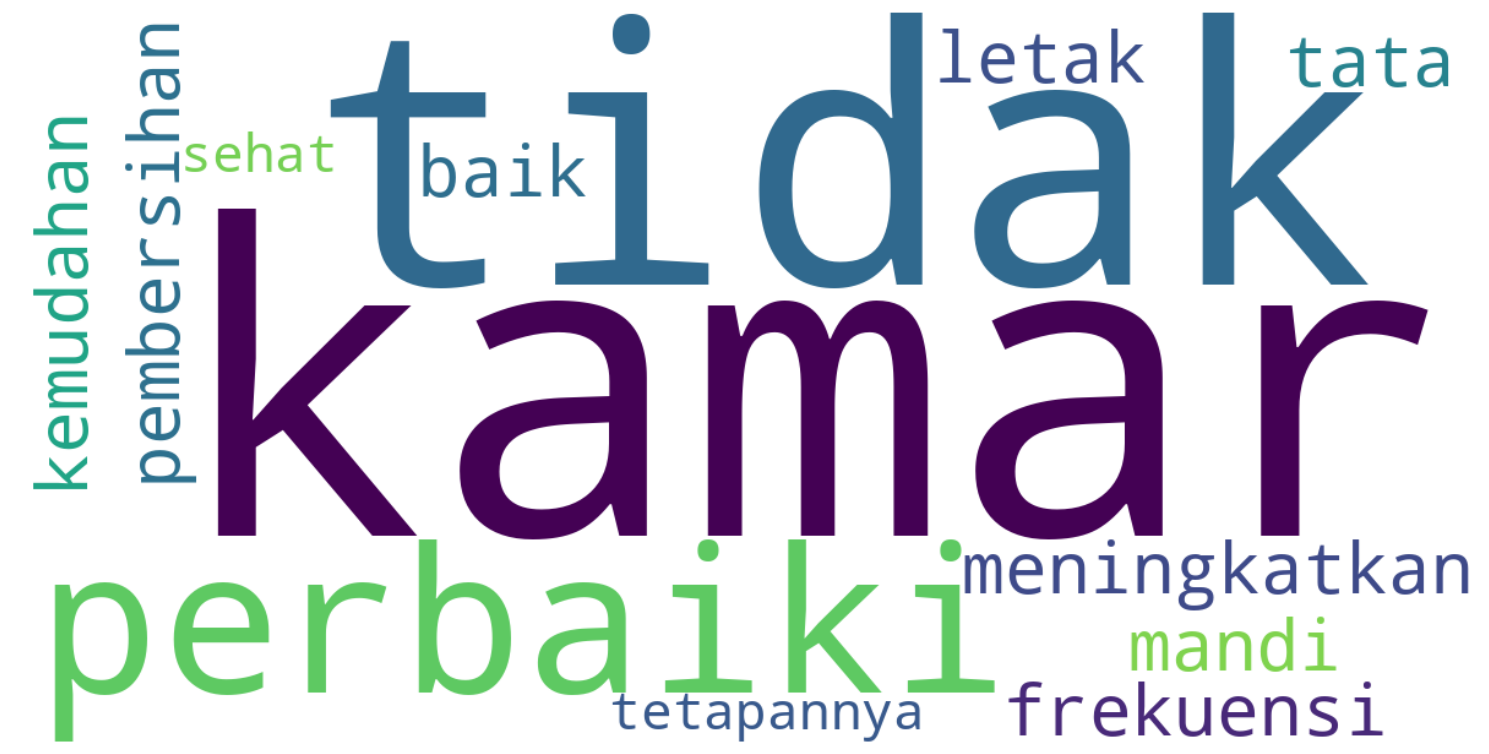

In [50]:
# Generate WordCloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='viridis',
    max_words=50,
    contour_width=1,
    contour_color='steelblue',
    font_path=None  # Ganti dengan path font jika ingin custom
).generate_from_frequencies(filtered_words)

# Tampilkan
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

# Simpan sebagai gambar
plt.savefig('wordcloud_rekomendasi.png', dpi=300, bbox_inches='tight')
plt.show()